In [1]:
print('Hello, world!')

Hello, world!


In [2]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
import warnings
from add_drive_cost import *

warnings.filterwarnings("ignore")


rd = pd.read_csv('rides.csv', sep=',', skipinitialspace=True)
wt = pd.read_csv('weather.csv', sep=',', skipinitialspace=True)
rd.columns = [i.lower().replace(' ', '_') for i in rd.columns]
wt.columns = [i.lower().replace(' ', '_') for i in wt.columns]
rd.end_date = pd.to_datetime(rd.end_date.astype(str).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if len(x) == 19 else pd.NA))
rd.start_date = pd.to_datetime(rd.start_date.astype(str).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if len(x) == 19 else pd.NA))
wt.datetime = wt.datetime.astype(str).apply(lambda x: dt.datetime.strptime(x.replace(' ', 'T'), '%Y-%m-%dT%H:%M:%S') if len(x) == 19 else pd.NA)
rd.drop_duplicates(subset=['id'], keep='first', inplace=True)

In [3]:
for i in rd.columns[4:8]:
    rd.loc[:, i] = rd[i].astype(str).apply(lambda x: x.lower().replace(' ', '_'))

# Предобработка данных, очистка от выбросов и заполнение пропусков
#### Для начала на табличке без пропусков найдём средние значения времени поездки, скорости, расстояния и т.п. для дальнейшего заполнения пропусков

In [4]:
rd['duration_sec'] = (rd['end_date'] - rd['start_date']).dt.total_seconds()

0.9336041157875818
0.0006653359946773121 5.311881188118812


,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration_sec,speed
0,0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,0,1422.0,2.861463
1,1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,0,1705.0,2.648094
2,2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,0,2299.0,1.966072
3,3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,0,1909.0,2.033002
4,4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,0,1840.0,2.189674
...,...,...,...,...,...,...,...,...,...,...,...,...
102250,102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,озерная,юго-восточный,первомайская,северо-западный,3302.0,0,1309.0,2.522536
102251,102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,мичурина,ленинский,садовая,заречный,4992.0,0,2374.0,2.102780
102252,102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,лермонтова,ленинский,куйбышева,центральный,2781.0,0,1277.0,2.177760
102253,102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,рябиновая,северо-западный,энергетиков,юго-восточный,6466.0,0,2783.0,2.323392


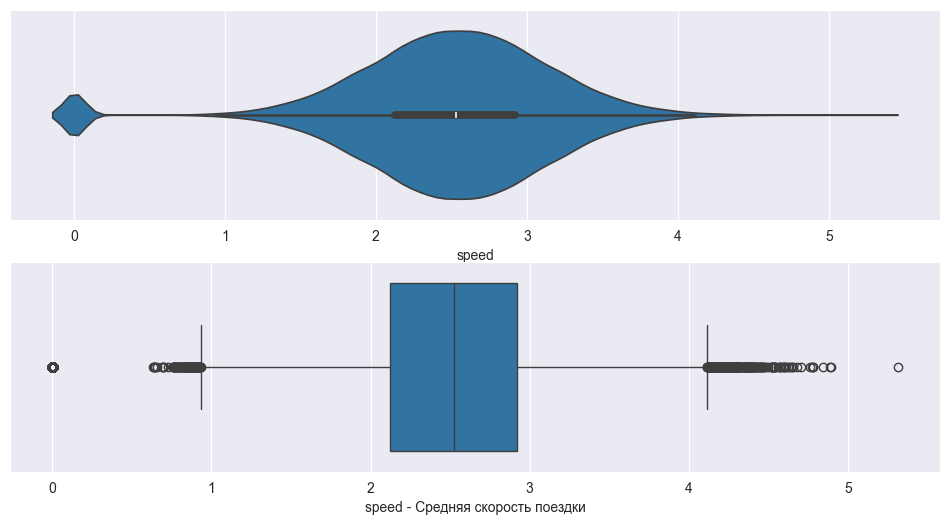

In [5]:
rd['speed'] = (rd.loc[:, 'distance'] / rd.loc[:, 'duration_sec']).astype(float)
rd['speed'] = rd['speed'].where(rd['speed'] <= 1000, pd.NA).dropna()  # находим скорость и ограничиваем экстремальные выбросы

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
sns.violinplot(rd.speed, orient='h', ax=axes[0])
sns.boxplot(rd.speed, orient='h', ax=axes[1])
plt.xlabel('speed - Средняя скорость поездки')
print(rd.speed.quantile(0.25) - 1.5 * (rd.speed.quantile(0.75) - rd.speed.quantile(0.25)))
print(min(rd.speed), max(rd.speed))
rd

5.311881188118812

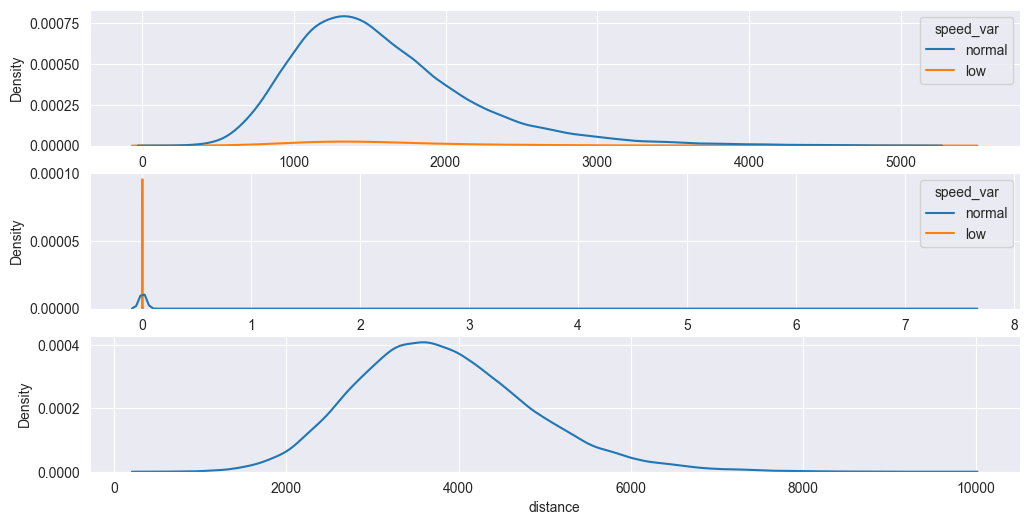

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
rd.loc[:, 'speed_var'] = rd.speed.apply(lambda x: 'low' if x <= 0.9336 else 'normal')
sns.kdeplot(data=rd, x='duration_sec', hue='speed_var', ax=axes[0])
sns.kdeplot(data=rd, x='distance', hue='speed_var', ax=axes[1])
sns.kdeplot(data=rd[rd['speed'] >= 1], x='distance', ax=axes[2])
max(rd.speed)

#### 5.31 м/с = 19.116 км/ч - вполне реальная величина скорости для самокатов, это намного ниже максимальной скорости большинства электросамокатов, а вот скорости, очень близкие к нулю - подозрительны, однако могут объясняться слишком большой продолжительностью поездки

<Axes: xlabel='duration_sec', ylabel='speed'>

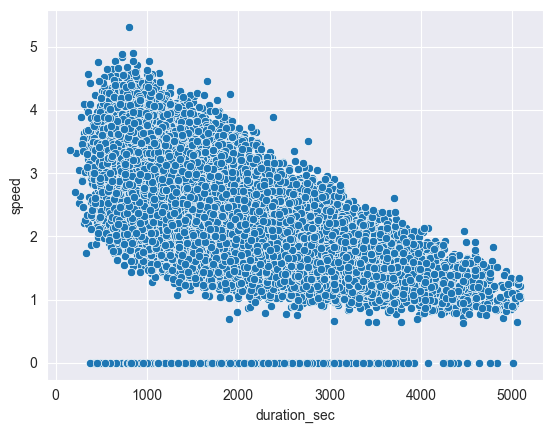

In [7]:
sns.scatterplot(data=rd, x='duration_sec', y='speed')

<Axes: xlabel='distance', ylabel='duration_sec'>

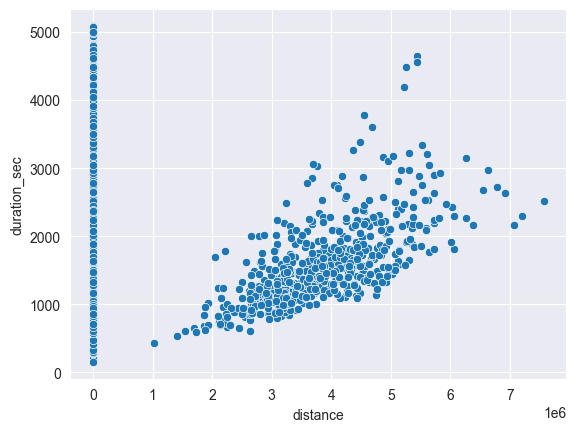

In [8]:
sns.scatterplot(data=rd, x='distance', y='duration_sec')

In [9]:
rd[rd['speed_var'] == 'low']

,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration_sec,speed,speed_var
8,8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,западная,ленинский,озерная,юго-восточный,3.0,0,1042.0,0.002879,low
21,21,100360,2023-04-22 10:01:51,2023-04-22 10:31:17,лермонтова,ленинский,дружбы,центральный,5.0,0,1766.0,0.002831,low
67,67,100405,2023-04-22 11:08:22,2023-04-22 12:00:35,ленина,ленинский,овражная,центральный,5.0,0,3133.0,0.001596,low
70,70,100408,2023-04-22 11:18:25,2023-04-22 11:36:19,ул._строительная,северо-западный,ул.строительная,северо-западный,4.0,0,1074.0,0.003724,low
108,108,100443,2023-04-22 12:16:46,2023-04-22 12:50:14,заводская,северо-западный,свердлова,центральный,4.0,0,2008.0,0.001992,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102007,102007,197473,2023-07-31 19:44:01,2023-07-31 20:29:57,гоголя,центральный,энтузиастов,центральный,3.0,0,2756.0,0.001089,low
102072,102072,197538,2023-07-31 20:23:15,2023-07-31 20:53:32,полевая,ленинский,ул.чапаева,северо-западный,3.0,0,1817.0,0.001651,low
102117,102117,197581,2023-07-31 20:57:53,2023-07-31 21:33:29,октябрьская,заречный,солнечная,центральный,6.0,0,2136.0,0.002809,low
102149,102149,197611,2023-07-31 21:22:02,2023-07-31 21:40:39,трудовая,центральный,гоголя,центральный,4.0,0,1117.0,0.003581,low


,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration_sec,speed,speed_var,go,time_quantile
26436,26436,125512,2023-05-21 17:37:51,2023-05-21 18:18:04,восточная,октябрьский,цветочная,северо_западный,3.0,0,2413.0,0.001243,low,цветочнаясеверо_западныйцветочнаясеверо_западный,10
60453,60453,157893,2023-06-23 20:26:39,2023-06-23 20:55:10,ул_победы,юго-восточный,ул_пушкина,центральный,5.0,0,1711.0,0.002922,low,ул_пушкинацентральныйул_пушкинацентральный,7
82346,82346,178762,2023-07-14 02:55:52,2023-07-14 03:14:14,ул_строительная,северо-западный,ул_калинина,ленинский,4.0,0,1102.0,0.003630,low,ул_калининаленинскийул_калининаленинский,2


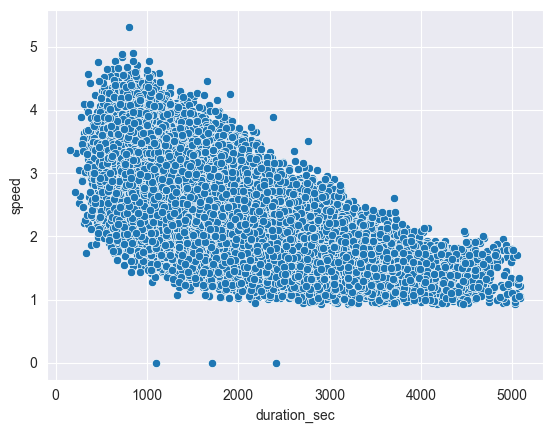

In [10]:
rd['go'] = rd.loc[:, 'end_location'] + rd.loc[:, 'end_district'] + rd.loc[:, 'end_location'] + rd.loc[:, 'end_district']
rd['time_quantile'] = pd.qcut(rd['duration_sec'], q=10, labels=range(1, 11))
mask = rd['speed'] < 0.9336

rd.loc[mask, 'speed'] = rd.groupby(['go', 'time_quantile'])['speed'].transform('mean')

rd['speed'] = rd['speed'].fillna(rd.groupby(['go', 'time_quantile'])['speed'].transform('mean'))

rd.loc[:, 'speed_var'] = rd.speed.apply(lambda x: 'low' if x <= 0.9336 else 'normal')
sns.scatterplot(data=rd, x='duration_sec', y='speed')
rd[rd['speed_var'] == 'low']

#### ...

<Axes: xlabel='distance', ylabel='Density'>

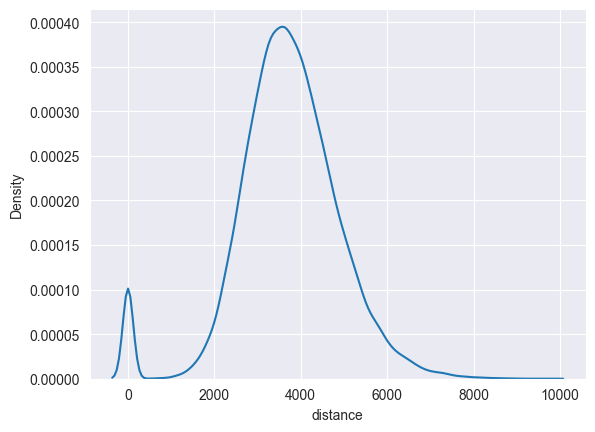

In [11]:
sns.kdeplot(data=rd[rd['distance'] < 100000], x='distance')

#### Скорее всего, поездки состоялись, но на определённых отрезках расстояние фиксируется неправильно, поэтому для заполнения пропусков в расстоянии мы будем использовать средние значения скорости по пунктам поездки (если будем использовать для заполнения общую среднюю скорость, то получим неправильные значения времени для отрезков с низкой скоростью).

154.0

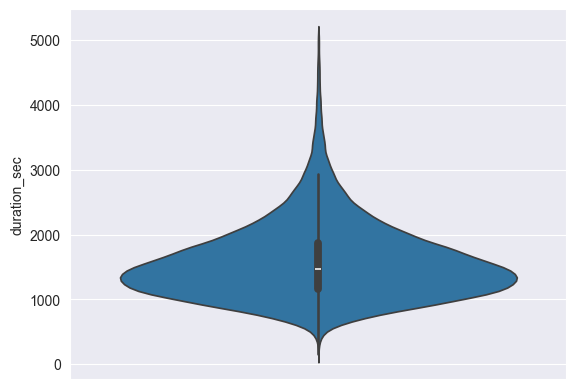

In [12]:
sns.violinplot(rd.duration_sec)
min(rd.duration_sec.where(rd.duration_sec >= 0).dropna())

In [13]:
import numpy as np

# Calculate duration_sec based on speed if it is missing
rd['duration_sec'] = rd['duration_sec'].fillna(rd['distance'] / rd['speed'])

# Fill in end_date based on start_date and duration_sec
rd['end_date'] = rd['start_date'] + pd.to_timedelta(rd['duration_sec'], unit='s')

In [14]:
rd

,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration_sec,speed,speed_var,go,time_quantile
0,0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,0,1422.0,2.861463,normal,майскаяоктябрьскиймайскаяоктябрьский,5
1,1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,0,1705.0,2.648094,normal,спортивнаяоктябрьскийспортивнаяоктябрьский,7
2,2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,0,2299.0,1.966072,normal,сувороваленинскийсувороваленинский,9
3,3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,0,1909.0,2.033002,normal,рабочаясеверо-западныйрабочаясеверо-западный,8
4,4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,0,1840.0,2.189674,normal,юбилейнаяюго-восточныйюбилейнаяюго-восточный,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102250,102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,озерная,юго-восточный,первомайская,северо-западный,3302.0,0,1309.0,2.522536,normal,первомайскаясеверо-западныйпервомайскаясеверо-...,4
102251,102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,мичурина,ленинский,садовая,заречный,4992.0,0,2374.0,2.102780,normal,садоваязаречныйсадоваязаречный,10
102252,102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,лермонтова,ленинский,куйбышева,центральный,2781.0,0,1277.0,2.177760,normal,куйбышевацентральныйкуйбышевацентральный,4
102253,102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,рябиновая,северо-западный,энергетиков,юго-восточный,6466.0,0,2783.0,2.323392,normal,энергетиковюго-восточныйэнергетиковюго-восточный,10


In [15]:
rd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97372 entries, 0 to 102254
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   unnamed:_0      97372 non-null  int64         
 1   id              97372 non-null  int64         
 2   start_date      97372 non-null  datetime64[ns]
 3   end_date        96817 non-null  datetime64[ns]
 4   start_location  97372 non-null  object        
 5   start_district  97372 non-null  object        
 6   end_location    97372 non-null  object        
 7   end_district    97372 non-null  object        
 8   distance        96191 non-null  float64       
 9   promo           97372 non-null  int64         
 10  duration_sec    96817 non-null  float64       
 11  speed           96814 non-null  float64       
 12  speed_var       97372 non-null  object        
 13  go              97372 non-null  object        
 14  time_quantile   96817 non-null  category      
dtypes: cat